In [49]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

In [50]:
import torch
import torch.nn as nn
import tiktoken

In [51]:
# Áp dụng vào lớp chuẩn hóa
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale*norm_x + self.shift

In [52]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            ( x + 0.044715 * torch.pow(x,3))
        ))

In [53]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # Kích thước ban đầu
            GELU(), # Mở rộng node ra 
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # Lại thu về kích thước ban đầu
        )

    def forward(self, x):
        return self.layers(x)

In [54]:
# Multihead Attention Class
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, 
                 context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads    #1
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)    #2
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)         #3
        queries = self.W_query(x)    #3
        values = self.W_value(x)     #3

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)       #4
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)  
        queries = queries.view(                                             
            b, num_tokens, self.num_heads, self.head_dim                    
        )                                                                   

        keys = keys.transpose(1, 2)          #5
        queries = queries.transpose(1, 2)    #5
        values = values.transpose(1, 2)      #5

        attn_scores = queries @ keys.transpose(2, 3)   #6
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]    #7

        attn_scores.masked_fill_(mask_bool, -torch.inf)     #8

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)   #9
 #10
        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )
        context_vec = self.out_proj(context_vec)    #11
        return context_vec

In [55]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
 #1
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut      #2

        shortcut = x         #3
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut      #4
        return x

In [56]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
 #1
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

---

Initialize the GPT Model

In [57]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,    #1
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12, 
    "drop_rate": 0.1,       #2
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

---
Hàm tạo sinh văn bản đơn giản

In [58]:
def generate_text_simple(model, idx,                 #1
                        max_new_tokens, context_size): 
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]    #2
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]                    #3
        probas = torch.softmax(logits, dim=-1)           #4
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)    #5
        idx = torch.cat((idx, idx_next), dim=1)     #6

    return idx

#1 idx is a (batch, n_tokens) array of indices in the current context.
#2 Crops current context if it exceeds the supported context size, e.g., if LLM supports only 5 tokens, and the context size is 10, then only the last 5 tokens are used as context
#3 Focuses only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)
#4 probas has shape (batch, vocab_size).
#5 idx_next has shape (batch, 1).
#6 Appends sampled index to the running sequence, where idx has shape (batch, n_tokens+1)

---
Hàm chuyển đổi văn bản thành token và hàm decode ngược lại

In [59]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text (token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M['context_length']
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


---
Calculating the text generation loss

In [60]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

In [61]:
targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107, 588, 11311]])  #  " really like chocolate"]

In [62]:
with torch.no_grad():     # Disables gradient tracking since we are not training yet
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)     #2
print(probas.shape)

torch.Size([2, 3, 50257])


In [63]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [64]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
      f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [65]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [66]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [67]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [68]:
neg_avg_log_probas = avg_log_probas * -1 
print(neg_avg_log_probas)

tensor(10.7940)


Làm phẳng 2 logit và target từ 3 chiều xuống 2 chiều

In [69]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [70]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


Perplexity - Độ phức tạp

In [71]:
perplexity = torch.exp(loss)
perplexity

tensor(48725.8203)

### 5.1.3 Tính toán sai số cho tập huấn luyện và tập xác thực ( validation )

In [72]:
# file_path = "the-verdict.txt"
# with open(file_path, "r", encoding="utf-8") as file:
#     text_data = file.read()

In [73]:
# total_characters = len(text_data)
# total_tokens = len(tokenizer.encode(text_data))
# print("Characters:", total_characters)
# print("Tokens:", total_tokens)

90% cho training và 10% cho validation

In [74]:
# train_ratio = 0.90
# split_idx = int(train_ratio * len(text_data))
# train_data = text_data[:split_idx]
# val_data = text_data[split_idx:]

---

Sử dụng lại các hàm ở section 2

In [75]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        
        token_ids = tokenizer.encode(text)
        
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
            
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [76]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last = True, num_workers = 0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle = shuffle,
        drop_last = drop_last,
        num_workers = num_workers
    )
    
    return dataloader

In [77]:
# torch.manual_seed(123)

# train_loader = create_dataloader_v1(
#     train_data,
#     batch_size=2,
#     max_length=GPT_CONFIG_124M["context_length"],
#     stride=GPT_CONFIG_124M["context_length"],
#     drop_last=True,
#     shuffle=True,
#     num_workers=0
# )
# val_loader = create_dataloader_v1(
#     val_data,
#     batch_size=2,
#     max_length=GPT_CONFIG_124M["context_length"],
#     stride=GPT_CONFIG_124M["context_length"],
#     drop_last=False,
#     shuffle=False,
#     num_workers=0
# )

In [78]:
# print("Train loader:")
# for x, y in train_loader:
#     print(x.shape, y.shape)

# print("\nValidation loader:")
# for x, y in val_loader:
#     print(x.shape, y.shape)

Tính toán cross entropy loss

In [79]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)         #1
    target_batch = target_batch.to(device)      
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [80]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)     #1
    else:
        num_batches = min(num_batches, len(data_loader))   #2
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()    #3
        else:
            break
    return total_loss / num_batches    #4

In [81]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)   #1
# with torch.no_grad():                                        #2
#     train_loss = calc_loss_loader(train_loader, model, device)    #3
#     val_loss = calc_loss_loader(val_loader, model, device)
# print("Training loss:", train_loss)
# print("Validation loss:", val_loss)

### Training the LLMs

In [82]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()  #1
    with torch.no_grad():                              #2
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

In [83]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))      #1
    model.train()

In [84]:
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []    #1
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):    #2
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()   #3
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()                     #4
            optimizer.step()                    #5
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:    #6
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        generate_and_print_sample(                      #7
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen

Test thử với AdamW , 10 epochs

In [85]:
# torch.manual_seed(123)
# model = GPTModel(GPT_CONFIG_124M)
# model.to(device)
# optimizer = torch.optim.AdamW(
#      model.parameters(),           #1
#     lr=0.0004, weight_decay=0.1
# )
# num_epochs = 10
# train_losses, val_losses, tokens_seen = train_model_simple(
#     model, train_loader, val_loader, optimizer, device,
#     num_epochs=num_epochs, eval_freq=5, eval_iter=5,
#     start_context="Every effort moves you", tokenizer=tokenizer
# )

In [86]:
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MaxNLocator
# def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
#     fig, ax1 = plt.subplots(figsize=(5, 3))
#     ax1.plot(epochs_seen, train_losses, label="Training loss")
#     ax1.plot(
#         epochs_seen, val_losses, linestyle="-.", label="Validation loss"
#     )
#     ax1.set_xlabel("Epochs")
#     ax1.set_ylabel("Loss")
#     ax1.legend(loc="upper right")
#     ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
#     ax2 = ax1.twiny()                   #1
#     ax2.plot(tokens_seen, train_losses, alpha=0)     #2
#     ax2.set_xlabel("Tokens seen")
#     fig.tight_layout()
#     plt.show()

# epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
# plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Kiểm soát việc tạo sinh ngẫu nhiên

In [87]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

Lấy ra thử đầu ra cho câu `Every effort moves you`

In [88]:
# tokenizer = tiktoken.get_encoding("gpt2")
# token_ids = generate_text_simple(
#     model=model,
#     idx=text_to_token_ids("Every effort moves you", tokenizer),
#     max_new_tokens=25,
#     context_size=GPT_CONFIG_124M["context_length"]
# )
# print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

#### Kỹ thuật thang nhiện độ - temperature scaling

Cách 2.1 : Sử dụng `multinomial` thay cho `softmax`

In [89]:
# next_token_id = torch.multinomial(probas, num_samples=1).item()

Cách 2: Sử dụng thang đo nhiệt độ - temperture scaling

In [90]:
# def softmax_with_temperature(logits, temperature):
#     scaled_logits = logits / temperature
#     return torch.softmax(scaled_logits, dim=0)

#### Kỹ thuật lấy mẫu top-k

In [91]:
# next_token_logits = torch.tensor(
#     [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
# )

Lấy ra top 3 logit cao nhất ( xác suất xuất hiện trong từ tiếp theo )

In [92]:
# top_k = 3
# top_logits, top_pos = torch.topk(next_token_logits, top_k)
# print("Top logits:", top_logits)
# print("Top positions:", top_pos)

Tiến hành masking các vị trí ko phải nằm trong top-k

In [93]:
# new_logits = torch.where(
#     condition=next_token_logits < top_logits[-1],    #1
#     input=torch.tensor(float('-inf')),     #2
#     other=next_token_logits     #3
# )
# print(new_logits)

Tiến hành sử dụng hàm softmax để chuẩn hóa giá trị của các logit này cộng lại bằng 1

In [94]:
# topk_probas = torch.softmax(new_logits, dim=0)
# print(topk_probas)

### 5.3.3 Áp dụng vào hàm tạo sinh để tăng sự đa dạng của các câu trả lời (output)

In [95]:
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):            #1
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:                # Top-K Sampling
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:                  # Temperture Scaling
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:    #4
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:              #5
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [96]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you inferred rolleduint fabricationagos remarkably hereuced saints freewaylookOkayRand salary baseless


### Lưu lại trọng số của mô hình thông qua Pytorch
Trong đó, ".pth" là đuôi file của Pytorch, nhưng ta có thể thay bằng bất kì phần mở rộng nào ( về mặt kỹ thuật )

In [97]:
# torch.save(model.state_dict(), "model.pth")

Đọc trọng số từ file cho một mô hình mới

In [98]:
# model = GPTModel(GPT_CONFIG_124M)
# model.load_state_dict(torch.load("model.pth", map_location=device))
# model.eval()

In [99]:
# torch.save({
#     "model_state_dict": model.state_dict(),
#     "optimizer_state_dict": optimizer.state_dict(),
#     }, 
#     "model_and_optimizer.pth"
# )

In [100]:
# checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
# model = GPTModel(GPT_CONFIG_124M)
# model.load_state_dict(checkpoint["model_state_dict"])
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# model.train();

### 5.5 Loading Pretrained Weights form OpenAI

In [101]:
# import urllib.request
# url = (
#     "https://raw.githubusercontent.com/rasbt/"
#     "LLMs-from-scratch/main/ch05/"
#     "01_main-chapter-code/gpt_download.py"
# )
# filename = url.split('/')[-1]
# urllib.request.urlretrieve(url, filename)

In [102]:
# from gpt_download import download_and_load_gpt2
# settings, params = download_and_load_gpt2(
#     model_size="124M", models_dir="gpt2"
# )

Tìm hiểu về config của model và các key của tham số

In [103]:
# print("Settings:", settings)
# print("Parameter dictionary keys:", params.keys())

In [104]:
# model_configs = {
#     "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
#     "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
#     "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
#     "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
# }

GPT 2 - SMALL (124M)

In [105]:
# model_name = "gpt2-small (124M)"
# NEW_CONFIG = GPT_CONFIG_124M.copy()
# NEW_CONFIG.update(model_configs[model_name])

In [106]:
# NEW_CONFIG.update({"context_length": 1024})

In [107]:
# NEW_CONFIG.update({"qkv_bias": True})

In [108]:
# gpt = GPTModel(NEW_CONFIG)
# gpt.eval()

In [109]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                          "Right: {right.shape}"
        )
    return torch.nn.Parameter(torch.tensor(right))

In [110]:
import numpy as np

def load_weights_into_gpt(gpt, params):           #1
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):     #2
        q_w, k_w, v_w = np.split(                            #3
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])    #4

In [111]:
# load_weights_into_gpt(gpt, params)
# gpt.to(device)

In [112]:
# torch.manual_seed(123)
# token_ids = generate(
#     model=gpt,
#     idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
#     max_new_tokens=25,
#     context_size=NEW_CONFIG["context_length"],
#     top_k=50,
#     temperature=1.5
# )
# print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

### 6.2 Chuẩn bị tập dữ liệu

In [113]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"


def download_and_unzip_spam_data(
        url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download "
              "and extraction."
        )
        return

    with urllib.request.urlopen(url) as response:    #1
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:    #2
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)               #3
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection\SMSSpamCollection.tsv


In [114]:
import pandas as pd
df = pd.read_csv(
    data_file_path, sep="\t", header=None, names=["Label", "Text"]
)
df      #1

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [115]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


Tạo một tập dữ liệu cân bằng

In [116]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]     #1
    ham_subset = df[df["Label"] == "ham"].sample(
        num_spam, random_state=123
    )                                         #2
    balanced_df = pd.concat([
        ham_subset, df[df["Label"] == "spam"]
    ])                               #3
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


Encode label

In [117]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

Split the dataset

In [118]:
def random_split(df, train_frac, validation_frac):

    df = df.sample(
        frac=1, random_state=123
    ).reset_index(drop=True)               #1
    train_end = int(len(df) * train_frac)          #2
    validation_end = train_end + int(len(df) * validation_frac)

 #3
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(
    balanced_df, 0.7, 0.1)                     #4

In [119]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [120]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None,
                 pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
 #1
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
 #2
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

 #3
        self.encoded_texts = [
            encoded_text + [pad_token_id] * 
            (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]


    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [121]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

In [122]:
print(train_dataset.max_length)

120


In [123]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

Create pytorch dataloader

In [124]:
from torch.utils.data import DataLoader

num_workers = 0      #1
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [125]:
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [126]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


### 6.4 Tạo model với trọng số tiền đào tạo

In [127]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,          #1
    "context_length": 1024,       #2
    "drop_rate": 0.0,             #3
    "qkv_bias": True              #4
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [130]:
from gpt_download import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

checkpoint: 100%|██████████| 77.0/77.0 [00:00<?, ?iB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:02<00:00, 506kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 90.3kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [04:24<00:00, 1.88MiB/s]   
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 5.23MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 297kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 338kiB/s]  


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [131]:
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [132]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [133]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

Đóng băng mô hình

In [134]:
for param in model.parameters():
    param.requires_grad = False

Thay thế lớp đầu ra bằng một lớp phân loại

In [ ]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"], # 768
    out_features=num_classes
)

Set require_grad = true cho lớp layernorm và block transformer cuối để có thể đào tạo được

In [136]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

#### Fine-Tuning The Whole Model

In [138]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)    #1

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [139]:
with torch.no_grad():
    outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [140]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


Áp dụng softmax để đưa kết quả về đoạn [0,1] sau đó chọn ra thằng cao nhất?

In [141]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


Hàm tính toán độ chính xác

In [142]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)


            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]     #1
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )

        else:
            break
    return correct_predictions / num_examples

In [143]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


Chỉnh sửa hàm tính cross entropy loss tập trung vào lớp cuối cùng

In [144]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :]     #1
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

Hàm tính loss cho một batch dữ liệu

In [145]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:                                        #1
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [146]:
with torch.no_grad():                 #1
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


### 6.7 Fine-Tuning The model on supervised data

In [147]:
def train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []   #1
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):    #2
        model.train()             #3

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()                      #4
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()                          #5
            optimizer.step()                          #6
            examples_seen += input_batch.shape[0]    #7
            global_step += 1

 #8
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

 #9
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )

        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [148]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

In [149]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5


train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=50,
        eval_iter=5
    )

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 4.60 mi

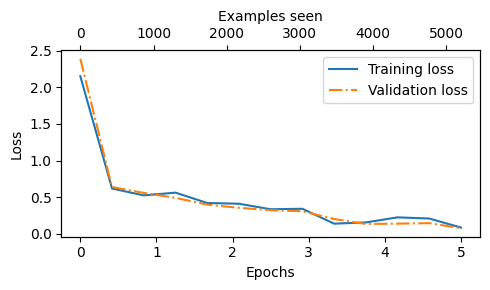

In [150]:
import matplotlib.pyplot as plt

def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
        label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

 #1
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

 #2
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)    #3
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()             #4
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

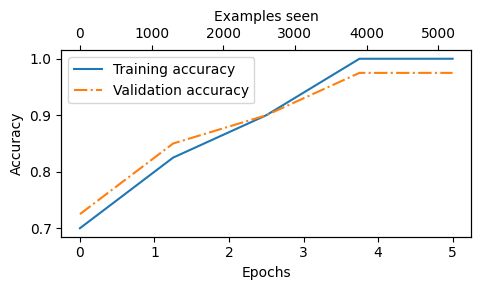

In [151]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(
    epochs_tensor, examples_seen_tensor, train_accs, val_accs,
    label="accuracy"
)

In [152]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


### Using the LLM as a spam classifier

In [153]:
def classify_review(
        text, model, tokenizer, device, max_length=None,
        pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)          #1
    supported_context_length = model.pos_emb.weight.shape[1]

    input_ids = input_ids[:min(              #2
        max_length, supported_context_length
    )]

    input_ids += [pad_token_id] * (max_length - len(input_ids))    #3

    input_tensor = torch.tensor(
        input_ids, device=device
    ).unsqueeze(0)              #4

    with torch.no_grad():                                #5
        logits = model(input_tensor)[:, -1, :]     #6
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"     #7

In [154]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [155]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [156]:
torch.save(model.state_dict(), "review_classifier.pth")